In [1]:
import pandas as pd
import h5py
from Bio import SeqIO
from copy import deepcopy 
import numpy as np
import seaborn as sns
from sklearn.neighbors import KernelDensity
from scipy.stats import norm
from sklearn.decomposition import PCA
import pickle
import re

from sklearn.linear_model import LogisticRegressionCV,LogisticRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,RocCurveDisplay
from matplotlib.colors import to_hex

import matplotlib.pyplot as plt
from scipy.stats import spearmanr,pearsonr,mannwhitneyu
from statsmodels.stats.multitest import multipletests
plt.rcParams['font.family'] = 'Arial'

def load_embedding(file_name):
    f = h5py.File(file_name)
    Xg = []
    gene_names = list(f.keys())
    for key in f.keys():
        Xg.append(f[key][()])
    f.close()
    Xg = pd.DataFrame(np.asmatrix(Xg),index=gene_names)
    return Xg,gene_names

kos = pd.read_csv("keggGeneNames.csv",index_col=0)

def compute_summary_stats(df):
    KOs = []
    Mo = []
    W = []
    for KO, dff in df.groupby('ko'):
        Mo.append((dff.predict == 'Mo').sum())
        W.append((dff.predict == 'W').sum())
        KOs.append(KO)
    results_predictions = pd.DataFrame({"KO":KOs,"Mo":Mo,"W":W})

    rp = results_predictions.set_index("KO").join(kos.set_index('KO'))

    rp['Mo (%)']= 100*rp['Mo']/(rp['Mo'] + rp['W'])
    rp['W (%)']= 100*rp['W']/(rp['Mo'] + rp['W'])
    return rp




In [2]:
#model = pd.read_pickle("lrmodel.l2reg.embedding2mow.10Jan2023.pkl")
model = pd.read_pickle("lrmodel.l1reg.embedding2mow.18Feb2023.pkl")


In [3]:
# load wells embedding
file_name = '../data/WellsSciRep2022/FDHChalcOR_wSerAspligands.embedding.29Nov2022.h5'
DMSOR_sm,gns = load_embedding(file_name)
predictions = model.predict(DMSOR_sm)
predictions = pd.DataFrame({'predictions':predictions},index=DMSOR_sm.index)

In [42]:
geneNames = []
taxaNames = []

for gene,row in predictions.iterrows():
    gene = gene[0].upper() + gene[1:]
    i = [ match.start() for match in re.finditer ("[A-Z]", gene) ][1]

    taxa = gene[0:i]
    genename = gene[i:]
    geneNames.append(genename)
    taxaNames.append(taxa)
    
#e = predictions.index.tolist()[0]

In [43]:
predictions["geneName"] = geneNames
predictions["taxa"] = taxaNames

In [54]:
len(predictions["geneName"].unique())

37

In [59]:
predictions[predictions["predictions"] == "W"].sort_values("geneName")

,predictions,geneName,taxa
MoorthermAOR,W,AOR,Moortherm
PyrococfurioAOR,W,AOR,Pyrococfurio
ThermococclitorFOR,W,FOR,Thermococclitor
PyrococfurioFOR,W,FOR,Pyrococfurio
ThermococconnuriFdhF420,W,FdhF420,Thermococconnuri
MethanococmaripaGAPOR,W,GAPOR,Methanococmaripa
PyroaerGAPOR,W,GAPOR,Pyroaer
PyrococfurioGAPOR,W,GAPOR,Pyrococfurio
ThermoficarboxPsrA,W,PsrA,Thermoficarbox
PyroneutroPsrA,W,PsrA,Pyroneutro


In [50]:
#@predictions[predictions["predictions"] == "W"]

In [45]:
mo_color = to_hex(sns.palettes.color_palette("Set2")[0])
w_color = to_hex(sns.palettes.color_palette("Set2")[1])
cmap = {}
cmap["Mo"] =mo_color
cmap["W"] =w_color

In [46]:
predictions.to_csv("../data/WellsSciRep2022/CofactorPredictions.DMSOR.l1reg18Feb2023.csv")

In [51]:
r = pd.DataFrame(predictions["predictions"].apply(lambda x: cmap[x]))

In [52]:
r.to_csv("../data/WellsSciRep2022/CofactorPredictions.Colors.DMSOR.l1reg18Feb2023..csv")

In [61]:
f = "../data/gtdb.pterinSeqs.embed.22Dec2022.h5"
pterinEmbeddingGTDB,gns = load_embedding(f)
predictions_pterinEmbeddingGTDB= model.predict(pterinEmbeddingGTDB)
predictions_pterinEmbeddingGTDB_probs = model.predict_proba(pterinEmbeddingGTDB)
predictions_pterinEmbeddingGTDB = pd.DataFrame({'predict':predictions_pterinEmbeddingGTDB},index=pterinEmbeddingGTDB.index)
del pterinEmbeddingGTDB

predictions_pterinEmbeddingGTDB['gene_id']= [x.split(' ')[0] for x in gns]
predictions_pterinEmbeddingGTDB.set_index("gene_id",inplace=True)

#gnt = pd.read_csv("../data/sequenceTable.pterinDomains.gtdb.22Dec2022.csv",index_col=0)
gnt = pd.read_csv("../data/pterin-binding-gtdb/sequenceTable.csv",index_col=0)

gnt['gene name'] = gnt['gene name'].apply(lambda x: x.replace('.',"_"))
predictions_pterinEmbeddingGTDB = predictions_pterinEmbeddingGTDB.join(gnt.set_index("gene name"))

In [65]:
predictions_pterinEmbeddingGTDB[predictions_pterinEmbeddingGTDB.KO.isin(["K03738"])].groupby("predict").count()


,KO,genome
predict,,
Mo,388,388
W,22920,22920


In [67]:
z = predictions_pterinEmbeddingGTDB[predictions_pterinEmbeddingGTDB.KO.isin(["K03738"])]

In [72]:
len(z[z.predict == "Mo"]) / len(z)

0.01664664492877982

In [77]:
sstats_tab_gtdb = compute_summary_stats(predictions_pterinEmbeddingGTDB,"KO")

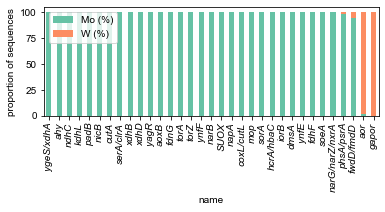

In [55]:
c =  sns.color_palette('Set2')[0:2]
#rbd = rp.set_index('gene_name')[['Mo (%)',"W (%)"]]
rbd = rp.set_index('gene_name')[['Mo (%)',"W (%)"]]
rbd['name'] = [x.replace(', ','/') for x in rbd.index.tolist()]
rbd.set_index("name",inplace=True)
rbd.sort_values("W (%)")[['Mo (%)',"W (%)"]].plot(kind='bar', stacked=True,figsize=(6,2),color=c)
plt.xticks(style="italic")
plt.ylabel("proportion of sequences")
plt.savefig("GeneFamilyMoWprediction.l1reg18Feb2023.svg")

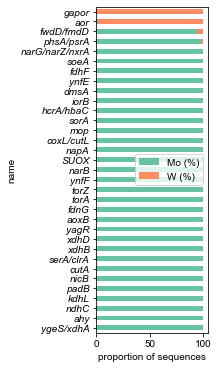

In [91]:
c =  sns.color_palette('Set2')[0:2]
#rbd = rp.set_index('gene_name')[['Mo (%)',"W (%)"]]
rbd = sstats_tab_gtdb.set_index('gene_name')[['Mo (%)',"W (%)"]]
rbd['name'] = [x.replace(', ','/') for x in rbd.index.tolist()]
rbd.set_index("name",inplace=True)
rbd.sort_values("W (%)")[['Mo (%)',"W (%)"]].plot(kind='barh', stacked=True,figsize=(2,6),color=c)
plt.yticks(style="italic")
plt.xlabel("proportion of sequences")
plt.savefig("GeneFamilyMoWprediction.Proportions.l1reg18Feb2023.Vertical.svg")

In [95]:
s = rbd.sort_values("W (%)")[['Mo (%)',"W (%)"]].index.tolist()

In [90]:
coeffs = pd.DataFrame(model.coef_).T
len(coeffs[np.abs(coeffs[0]) > 0])

10

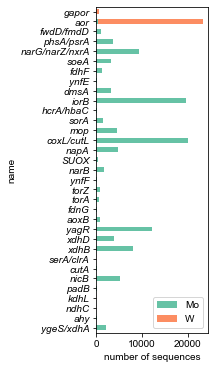

In [99]:
c =  sns.color_palette('Set2')[0:2]
#fields = ['Mo (%)',"W (%)"]
#rbd = rp.set_index('gene_name')[fields]
rbd = sstats_tab_gtdb.set_index('gene_name')[['Mo',"W"]]
rbd['total']=rbd['Mo'] + rbd['W']
rbd['name'] = [x.replace(', ','/') for x in rbd.index.tolist()]
rbd.set_index("name",inplace=True)
#rbd.sort_values("total")[["Mo","W"]].plot(kind='barh', stacked=True,figsize=(2,6),color=c)
rbd.loc[s][["Mo","W"]].plot(kind='barh', stacked=True,figsize=(2,6),color=c)
plt.yticks(style="italic")
plt.xlabel("number of sequences")
plt.savefig("GeneFamilyMoWprediction.TrotalAund.l1reg18Feb2023.Vertical.svg")

In [ ]:
c =  sns.color_palette('Set2')[0:2]
#rbd = rp.set_index('gene_name')[['Mo (%)',"W (%)"]]
rbd = rp.set_index('gene_name')[['Mo',"W"]]
rbd['total']=rbd['Mo'] + rbd['W']
rbd['name'] = [x.replace(', ','/') for x in rbd.index.tolist()]
rbd.set_index("name",inplace=True)
rbd.sort_values("total")[["Mo","W"]].plot(kind='barh', stacked=True,figsize=(2,6),color=c)
plt.yticks(style="italic")

In [76]:
#kos = pd.read_csv("keggGeneNames.csv",index_col=0)

# define model for predictins
#model = deepcopy(clf_all)

gene_families = pd.read_csv("../data/pterinBindingGenesKegg.csv",index_col=0)
f = '../data/pterinDomainsEmbedding.23Dec2022.h5'
pterinEmbedding,gns = load_embedding(f)
predictions_pterinEmbedding= model.predict(pterinEmbedding)
predictions_pterinEmbedding = pd.DataFrame({'predict':predictions_pterinEmbedding},index=pterinEmbedding.index)
predictions_pterinEmbedding['gene'] = [x.split(' ')[0] for x in predictions_pterinEmbedding.index.tolist()]
predictions_pterinEmbedding.set_index('gene',inplace=True)
predictions_pterinEmbedding = predictions_pterinEmbedding.join(gene_families.set_index('gene'))
predictions_pterinEmbedding = predictions_pterinEmbedding[predictions_pterinEmbedding.ko.apply(lambda x: type(x) == str)]
predictions_pterinEmbedding['ko'] = predictions_pterinEmbedding['ko'].apply(lambda x: x.split(":")[1])


file_name = '../data/K00201.kegg.h5'
KEGG_sm,gns = load_embedding(file_name)
predictions_kegg_K00201 = model.predict(KEGG_sm)
predictions_kegg_K00201 = pd.DataFrame(predictions_kegg_K00201)[0].values
predictions_kegg_K00201 = pd.DataFrame({'predict':predictions_kegg_K00201},index=KEGG_sm.index)
predictions_kegg_K00201['gene'] = [x.split(' ')[0] for x in predictions_kegg_K00201.index.tolist()]
predictions_kegg_K00201.set_index("gene",inplace=True)
predictions_kegg_K00201['ko'] = 'K00201'
#predictions_pterinEmbedding = pd.concat([predictions_pterinEmbedding,predictions_kegg_K00201],axis=0)


sstats_tab_kegg = compute_summary_stats(predictions_pterinEmbedding,"ko")

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41]),
 [Text(0, 0, 'cdhA'),
  Text(0, 1, 'ddhA'),
  Text(0, 2, 'serA/clrA'),
  Text(0, 3, 'ahy'),
  Text(0, 4, 'ndhC'),
  Text(0, 5, 'kdhL'),
  Text(0, 6, 'AAO4'),
  Text(0, 7, 'hcrA/hbaC'),
  Text(0, 8, 'padB'),
  Text(0, 9, 'cutA'),
  Text(0, 10, 'AAO1_2'),
  Text(0, 11, 'gapor'),
  Text(0, 12, 'aoxB'),
  Text(0, 13, 'ynfF'),
  Text(0, 14, 'sorA'),
  Text(0, 15, 'mop'),
  Text(0, 16, 'fwdD/fmdD'),
  Text(0, 17, 'ynfE'),
  Text(0, 18, 'AAO3'),
  Text(0, 19, 'xdhD'),
  Text(0, 20, 'ygeS/xdhA'),
  Text(0, 21, 'soeA'),
  Text(0, 22, 'narB'),
  Text(0, 23, 'torA'),
  Text(0, 24, 'NR'),
  Text(0, 25, 'phsA/psrA'),
  Text(0, 26, 'fwdB/fmdB'),
  Text(0, 27, 'fdnG'),
  Text(0, 28, 'torZ'),
  Text(0, 29, 'AOX'),
  Text(0, 30, 'nicB'),
  Text(0, 31, 'fdhF'),
  Text(0, 32, 'dmsA'),
  Text(0, 33, 'SUOX'),
  Text

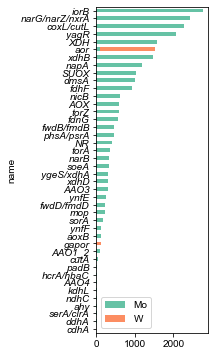

In [60]:
c =  sns.color_palette('Set2')[0:2]
#rbd = rp.set_index('gene_name')[['Mo (%)',"W (%)"]]
rbd = rp_kegg.set_index('gene_name')[['Mo',"W"]]
rbd['total']=rbd['Mo'] + rbd['W']
rbd['name'] = [x.replace(', ','/') for x in rbd.index.tolist()]
rbd.set_index("name",inplace=True)
rbd.sort_values("total")[["Mo","W"]].plot(kind='barh', stacked=True,figsize=(2,6),color=c)
plt.yticks(style="italic")

In [64]:
f = "../data/K00201.embed.gtdb.h5"
K00201gtdb,gns = load_embedding(f)
predictions_K00201gtdb= model.predict(K00201gtdb)
predictions_K00201gtdb = pd.DataFrame({'predict':predictions_K00201gtdb},index=K00201gtdb.index)
predictions_K00201gtdb['gene_id']= [x.split(' ')[0] for x in gns]
predictions_K00201gtdb.set_index("gene_id",inplace=True)
del K00201gtdb

#f = "../data/gtdb.pterinSeqs.embed.22Dec2022.h5"
#pterinEmbeddingGTDB,gns = load_embedding(f)
#predictions_pterinEmbeddingGTDB= clf.predict(pterinEmbeddingGTDB)
#predictions_pterinEmbeddingGTDB = pd.DataFrame({'predict':predictions_pterinEmbeddingGTDB},index=pterinEmbeddingGTDB.index)
#predictions_pterinEmbeddingGTDB['gene_id']= [x.split(' ')[0] for x in gns]
#predictions_pterinEmbeddingGTDB.set_index("gene_id",inplace=True)
#del pterinEmbeddingGTDB

seqtab = pd.read_csv("../data/K00201.gtdb.seqtable.csv",index_col=0)
seqtab['gene name'] = seqtab['gene name'].apply(lambda x: x.replace('.',"_"))
predictions_K00201gtdb = predictions_K00201gtdb.join(seqtab.set_index('gene name'))

gnt = pd.read_csv("../data/sequenceTable.pterinDomains.gtdb.22Dec2022.csv",index_col=0)
gnt['gene name'] = gnt['gene name'].apply(lambda x: x.replace('.',"_"))
#predictions_pterinEmbeddingGTDB = predictions_pterinEmbeddingGTDB.join(gnt.set_index("gene name"))

predictions_pterinEmbeddingGTDB_K00201 = pd.concat([predictions_pterinEmbeddingGTDB,predictions_K00201gtdb],axis=0)
